# Install

In [ ]:
import os
import logging

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/Colab Notebooks/MarkerMap0/Explore"
os.chdir(path)
os.listdir(path)

Mounted at /content/gdrive


['Zeisel_recon.ipynb',
 'data',
 'src',
 'Zeisel.ipynb',
 '.lr_find_a1ec6ab7-0364-4350-a647-312d131c420e.ckpt',
 '.lr_find_0aca0c4f-966b-403c-aab3-98f2ded7bc86.ckpt',
 '.lr_find_248ad01a-b172-4f61-9b9c-a21b621a18f2.ckpt',
 '.lr_find_78c49f15-ea8f-4f95-8207-617891f47547.ckpt',
 '.lr_find_3092afbd-b28c-4553-8928-3e18b3c9d08c.ckpt',
 '.lr_find_2e64d76d-bcc4-42c1-b92f-5e1db7aa8f52.ckpt',
 'CITEseq_recon.ipynb']

In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/MarkerMap0/Explore"
!ls

/content
CITEseq_recon.ipynb  data  src	Zeisel.ipynb  Zeisel_recon.ipynb


In [ ]:
!python -m pip install lassonet==0.0.9
!python -m pip install pytorch-lightning
!python -m pip install scanpy
!python -m pip install seaborn
!python -m pip install smashpy
!python -m pip install umap-learn
!python -m pip install scikit-learn
!python -m pip install typing-extensions --upgrade
!python -m pip install matplotlib==3.1.3
!python -m pip install scprep

In [ ]:
os.kill(os.getpid(), 9)

In [ ]:
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import path

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import scprep
import scanpy as sc

from src.myexp import recon
from src.myexp import classifier
from src.myexp import PEDCC, PEDCCclassifier
from src.markermap.vae_models import train_save_model, train_model, load_model
from src.markermap.vae_models import MarkerMap
from src.markermap.utils import (
    new_model_metrics,
    plot_confusion_matrix,
    plot_umap_embedding,
    log_and_normalize
)

In [ ]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

#pytorch lightning stuff
gpus = None
tpu_cores = None
precision=32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0


In [ ]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
torch.cuda.is_available()

True

In [ ]:
from os import path
dataset_dir = './data/zeisel/'
model_save_path = './data/zeisel/models/'
viz_save_path = './data/zeisel/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')

## Load Data

In [ ]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder


def _get_zeisel(zeisel_data_mat_file_path, zeisel_names_file_path):
    """
    Replacement of `get_zeisel` for loading `zeisel_data.mat` and `zeisel_names.mat` with same return value as original function.
    `zeisel_data.mat` contains the raw scRNA-seq counts.
    `zeisel_names.mat` contains the names (string labels) of the cells.

    Author: Jifeng Wu

    :param str zeisel_data_mat_file_path: The file path of `zeisel.mat`
    :param str zeisel_names_file_path: The file path of `zeisel_names.mat`
    """
    zeisel_data_mat = loadmat(zeisel_data_mat_file_path)
    zeisel_names = loadmat(zeisel_names_file_path)
    
    # Get the scRNA-seq count matrix, with each row being a cell and each column being a gene.
    X = zeisel_data_mat['zeisel_data'].T.astype(np.float32)
    
    # Get the names (string labels) of the cells.
    names = np.array([ element[0][0] for element in zeisel_names['zeisel_names'] ])
    
    # Create a `LabelEncoder` and fit `names`.
    encoder = LabelEncoder()
    encoder.fit(names)
    
    # Generate the numerical labels.
    y = encoder.transform(names)
    
    # Same return value as original function.
    return X, y, encoder

In [ ]:
X, y, encoder = _get_zeisel('./data/zeisel/zeisel_data.mat', './data/zeisel/zeisel_names.mat')
input_size = X.shape[1]

In [ ]:
print(len(y))
[list(y).count(i) for i in np.unique(y)]

3005


[224, 235, 290, 98, 820, 939, 399]

# Data explore & test

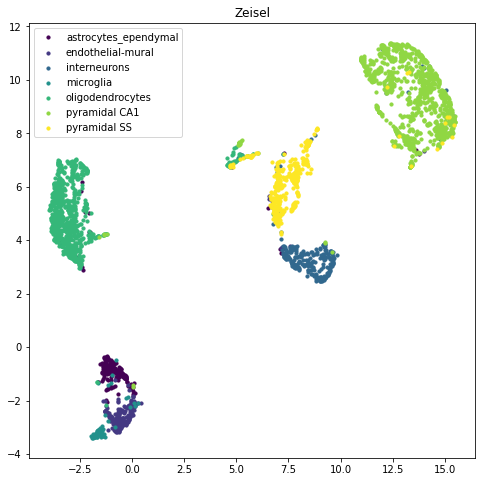

In [ ]:
plot_umap_embedding(X, y, encoder, title = "Zeisel")

In [ ]:
scprep.measure.gene_capture_count(X, cutoff=0)

array([3004, 2998, 2997, ..., 1112, 1112, 1111])

/usr/local/lib/python3.8/dist-packages/scprep/select.py:369: UserWarning: No selection conditions provided. Returning all columns.
  warnings.warn(


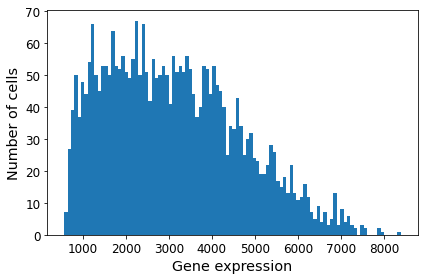

In [ ]:
scprep.plot.plot_gene_set_expression(X)

In [ ]:
from src.markermap.utils import log_and_normalize

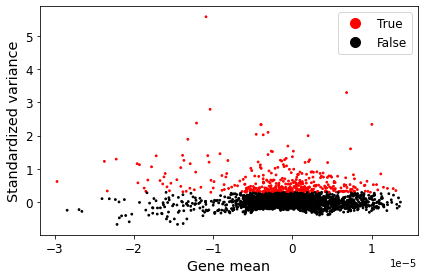

In [ ]:
var_X= scprep.measure.gene_variability(X)
scprep.plot.plot_gene_variability(X)

In [ ]:
names = list(range(0,X.shape[1]))

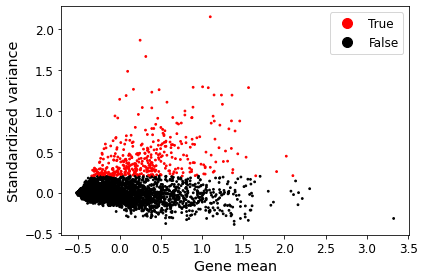

In [ ]:
X1 = log_and_normalize(X)
var_X1 = scprep.measure.gene_variability(X1)
scprep.plot.plot_gene_variability(X1)

In [ ]:
np.sum(var_X1<=0)

1999

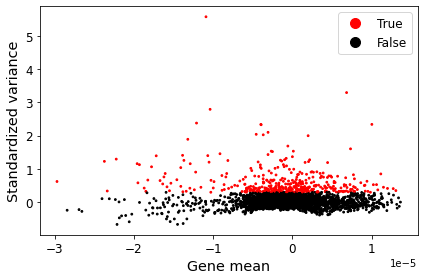

In [ ]:
X2 = scprep.normalize.batch_mean_center(X)
var_X2 = scprep.measure.gene_variability(X2)
scprep.plot.plot_gene_variability(X2)

## Try different pre normalization on gumbel sampling
Markermap is better on batch-mean-center normalization


In [ ]:
from src.markermap.vae_models import MarkerMap

In [ ]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

In [ ]:
# Org data
train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
          k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
          batch_norm = batch_norm, loss_tradeoff = 0.5)
# tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
tmp_path = model_save_path + 'markermap_org_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
var_X2[markers]

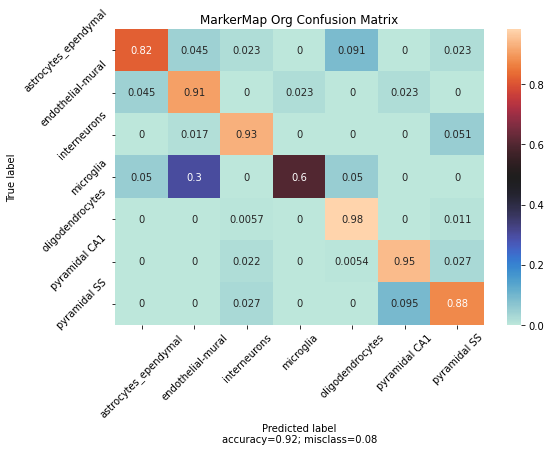

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'MarkerMap Org Confusion Matrix', save_path = None, cmap = 'icefire')

In [ ]:
train_x = X1[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X1[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X1, y, train_indices, val_indices)
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
          k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
          batch_norm = batch_norm, loss_tradeoff = 0.5)
# tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
tmp_path = model_save_path + 'markermap_lognormalize_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
results

In [ ]:
var_X2[markers]

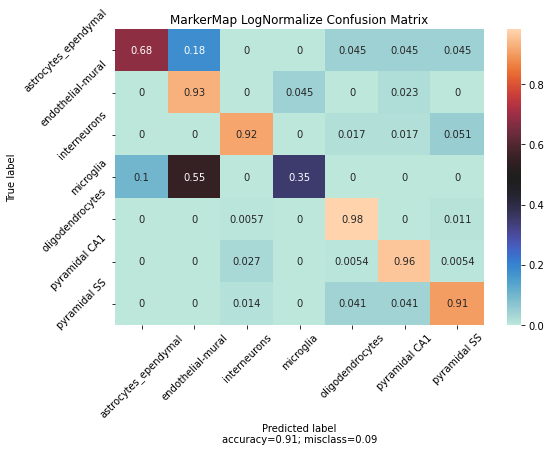

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'MarkerMap LogNormalize Confusion Matrix', save_path = None, cmap = 'icefire')

In [ ]:
train_x = X2[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X2[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X2, y, train_indices, val_indices)
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
         batch_norm = batch_norm, loss_tradeoff = 0.5)
# tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
tmp_path = model_save_path + 'markermap_batchmeancenter_{}.ckpt'.format(tryy)
# DO NOT USE IN OTHER WORKLOADS
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
results

In [ ]:
print(np.mean(var_X2[markers]))
var_X2[markers]

0.12683457


array([-2.3402572e-01, -2.5892240e-01,  5.7244480e-01,  7.5486124e-01,
       -7.4189901e-04,  2.6845098e-01,  2.6605773e-01,  2.9701668e-01,
        4.5223117e-01,  3.5464489e-01, -5.8707333e-01,  0.0000000e+00,
        5.4089034e-01,  1.3157260e-01,  1.6838539e-01, -6.7017949e-01,
        1.4076549e-01, -3.1598222e-01, -2.4905890e-01,  4.1290450e-01,
       -6.8261206e-02, -2.5843626e-01,  5.4870665e-02,  3.9085102e-01,
        8.1071758e-01, -5.0614840e-01, -2.6167089e-01,  1.3294649e-01,
        2.0249796e-01,  2.5136489e-01,  2.3995042e-01,  8.1769967e-01,
        2.9052374e-01, -4.0974173e-01,  1.0030270e-02,  6.6383994e-01,
        2.2000790e-02, -3.3071303e-01,  3.0558056e-01,  6.5736777e-01,
        2.0156443e-01,  1.4893800e-01,  5.5673218e-01, -6.4505208e-01,
        6.2034559e-01,  1.1229783e-01, -2.5830114e-01,  5.2651811e-01,
        3.2858020e-01, -3.0940741e-01], dtype=float32)

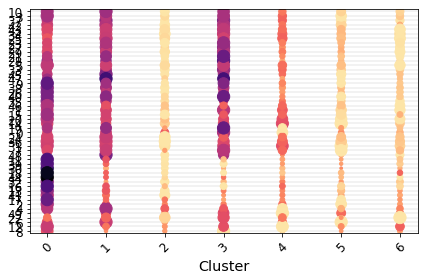

In [ ]:
markers = model.markers().clone().cpu().detach().numpy()
scprep.plot.marker_plot(X2, y, markers, names)

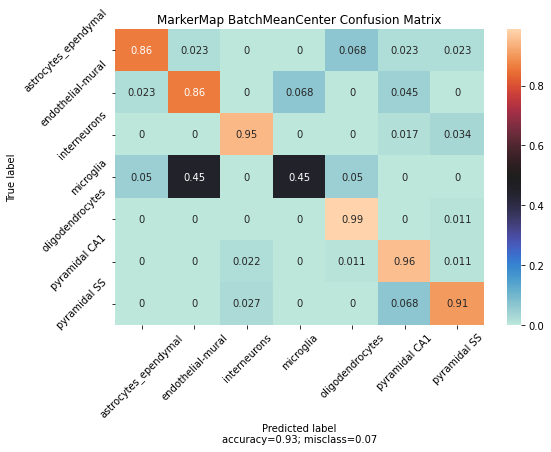

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'MarkerMap BatchMeanCenter Confusion Matrix', save_path = None, cmap = 'icefire')

In [ ]:
train_x = X2[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X2[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X2, y, train_indices, val_indices)

model = classifier.GumbelFCClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

tmp_path = model_save_path + 'gumbel_classification_batchmeancenter_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

In [ ]:
print(np.mean(var_X2[markers]))
var_X2[markers]

0.12683457


array([-2.3402572e-01, -2.5892240e-01,  5.7244480e-01,  7.5486124e-01,
       -7.4189901e-04,  2.6845098e-01,  2.6605773e-01,  2.9701668e-01,
        4.5223117e-01,  3.5464489e-01, -5.8707333e-01,  0.0000000e+00,
        5.4089034e-01,  1.3157260e-01,  1.6838539e-01, -6.7017949e-01,
        1.4076549e-01, -3.1598222e-01, -2.4905890e-01,  4.1290450e-01,
       -6.8261206e-02, -2.5843626e-01,  5.4870665e-02,  3.9085102e-01,
        8.1071758e-01, -5.0614840e-01, -2.6167089e-01,  1.3294649e-01,
        2.0249796e-01,  2.5136489e-01,  2.3995042e-01,  8.1769967e-01,
        2.9052374e-01, -4.0974173e-01,  1.0030270e-02,  6.6383994e-01,
        2.2000790e-02, -3.3071303e-01,  3.0558056e-01,  6.5736777e-01,
        2.0156443e-01,  1.4893800e-01,  5.5673218e-01, -6.4505208e-01,
        6.2034559e-01,  1.1229783e-01, -2.5830114e-01,  5.2651811e-01,
        3.2858020e-01, -3.0940741e-01], dtype=float32)

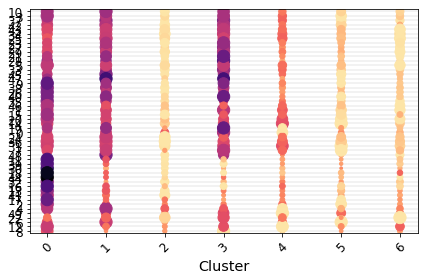

In [ ]:
# names = range(0,X.shape[1])
scprep.plot.marker_plot(X2, y, markers, names)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

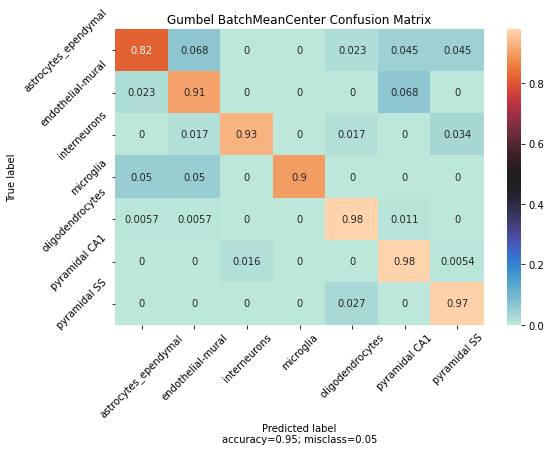

In [ ]:
results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
plot_confusion_matrix(results[2], encoder.classes_, 
        title = 'Gumbel BatchMeanCenter Confusion Matrix', save_path = None, cmap = 'icefire')

In [ ]:
tmp_path = model_save_path + 'gumbel_classification_batchmeancenter_recon_{}.ckpt'.format(tryy)
# marker_indices = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle=True)
marker_indices = markers
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
# np.save(model_save_path + 'gumbel_classification_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.538116518406255 [28.75086929 29.42330782 37.36180929 30.30379591 31.90008956 34.94837087
 37.00482815]
0.7640573318632855 [0.52235966 0.4571949  0.36869119 0.46386093 0.51802657 0.43240824
 0.42729706] 0.9186726459795402 [0.73849072 0.6726762  0.71762249 0.67425342 0.77279728 0.77855082
 0.72188961] 0.0 [0. 0. 0. 0. 0. 0. 0.]



# Recon on markers

In [ ]:
import sys
from importlib import reload
recon = reload(sys.modules['src.myexp.recon'])

## Markermap Unsupervised

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    tmp_path = model_save_path + 'marker_map_unsupervised_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'marker_map_unsupervised_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()


In [ ]:
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)

34.13591644170272 [31.87232953 31.7168857  35.8395337  32.48043662 33.88725919 34.60502829
 36.22764512]
0.7021276595744681 [0.40105079 0.46654445 0.3400335  0.39372822 0.46788991 0.46252285
 0.46788991] 0.8984288397564162 [0.58467859 0.65548714 0.70261752 0.58280246 0.72524275 0.78704928
 0.71261524] 0.0 [0. 0. 0. 0. 0. 0. 0.]


In [ ]:
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                            k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
load_model(model, model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(1))
recon_test_x = model.get_reconstruction(test_x)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

tryy= 1 : 
74.77370697070504 [50.61435576 50.27978902 88.72379147 48.75745733 63.51778046 89.95032461
 88.28893301]
0.11731843575418995 [0.11653873 0.11809923 0.09514031 0.12676056 0.12123336 0.11888112
 0.11888112] 0.011599484601055239 [ 0.03056733 -0.00748588  0.00287396  0.02871969  0.00714383  0.01535713
  0.0141063 ] 0.23165383393599742 [0.02661224 0.68200299 0.42790562 0.03466989 0.32574973 0.16576824
 0.18621622]



## Markermap Supervised

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'marker_map_supervised_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'marker_map_supervised_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.688238117084225 [29.25353515 29.44007103 37.3273534  30.10183023 32.05323103 35.05981094
 37.35650714]
0.7467248908296943 [0.4995314  0.41969831 0.3864818  0.37103685 0.50517404 0.43755615
 0.42984808] 0.9214526375402328 [0.73865747 0.63661028 0.71172841 0.52990551 0.78465621 0.79934191
 0.73043032] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 8.28271568e-289
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.139022574293605 [29.17040523 28.36041039 36.70423295 28.22034256 32.55465834 34.54528454
 35.90909645]
0.7937219730941704 [0.55793574 0.48285449 0.24223602 0.43755615 0.48285449 0.45586897
 0.48423006] 0.9291775452610965 [0.74455964 0.69708114 0.53014864 0.65110968 0.79214304 0.7906873
 0.77023812] 0.0 [0.0000000e+000 0.0000000e+000 4.0439969e-289 0.0000000e+000
 0.0000000e+000 0.0000000e+000 0.0000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.37889236778278 [29.83018498 28.14469622 36.33358571 29.74612418 32.0870743  34.65648018
 36.22466101]
0.7699115044247787 [0.58102767 0.51802657 0.36986301 0.45985401 0.56097561 0.45322434
 0.43626571] 0.9271113866251282 [0.79185218 0.71174738 0.73801989 0.65372806 0.8427343  0.80656658
 0.71958973] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.476173263217724 [31.37242492 29.98842593 37.18338319 28.77489238 31.74698154 34.77285115
 36.17243024]
0.7679558011049724 [0.48011101 0.47194112 0.35708227 0.50517404 0.56402737 0.43240824
 0.34680135] 0.9269897866868615 [0.72378863 0.67673171 0.73072172 0.67897893 0.84214873 0.78309666
 0.67515222] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
33.30852869679665 [29.23307188 29.09329888 36.43935696 30.02351948 31.87528907 34.54131989
 36.51007725]
0.7797552836484983 [0.52817574 0.53110048 0.33333333 0.45852325 0.5503876  0.45985401
 0.42095915] 0.9283618676096506 [0.72706262 0.74842852 0.71780522 0.67912375 0.836524   0.79487861
 0.67671028] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.70592676781965 [32.01413367 29.1655413  37.3213906  29.82381316 31.96797758 34.68556869
 36.2072495 ]
0.7410228509249184 [0.50659134 0.50517404 0.33891213 0.3536379  0.56555773 0.43626571
 0.37103685] 0.9216905535863638 [0.7382637  0.72369415 0.68320194 0.55437531 0.86442474 0.78657664
 0.69987136] 0.0 [0.000e+000 0.000e+000 0.000e+000 1.843e-321 0.000e+000 0.000e+000
 0.000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.48780934282692 [29.59635322 29.39483765 38.06311376 28.35480105 32.12911779 34.85441928
 36.10937441]
0.7817371937639198 [0.54738878 0.50659134 0.35021097 0.37931034 0.56862745 0.44014401
 0.46118721] 0.9287605298600329 [0.76003451 0.70221486 0.70766947 0.6010131  0.83284576 0.78591272
 0.76572989] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
33.498678025958576 [30.36516602 29.7074103  36.97529989 28.77040755 31.83176574 34.60302016
 36.41756583]
0.7917133258678611 [0.47194112 0.46252285 0.33000831 0.33111481 0.55642023 0.43497758
 0.45454545] 0.9404999500312469 [0.6950578  0.66047524 0.68139741 0.51621236 0.849311   0.7974912
 0.74318327] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.12467395e-271
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
34.149713344027 [30.06861323 30.21132489 37.10802475 30.63029542 31.77364759 35.71494908
 36.85860554]
0.7857142857142857 [0.52380952 0.51802657 0.32013201 0.44927536 0.59680639 0.44144144
 0.40969163] 0.9313581655223853 [0.70627391 0.7431917  0.66991944 0.6526407  0.84816284 0.77810188
 0.70981851] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
33.1465135842255 [28.90024184 28.34641944 35.92005061 30.02543405 32.41251216 34.55618745
 36.32900084]
0.7797552836484983 [0.47601476 0.43755615 0.38288678 0.3986014  0.5625     0.46118721
 0.41843972] 0.9303383008336437 [0.69028576 0.59791169 0.70560017 0.59611803 0.84515449 0.81866898
 0.73695053] 0.0 [0. 0. 0. 0. 0. 0. 0.]



## Markermap Mixed

In [ ]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'marker_map_mixed_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'marker_map_mixed_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.02009677714746 [28.71644232 28.88367635 36.4951516  29.696019   31.62132961 34.26741474
 36.35586768]
0.7486338797814208 [0.49393091 0.42857143 0.35249366 0.38050043 0.48285449 0.43884892
 0.4059754 ] 0.9115985496738905 [0.72038093 0.64887195 0.69744861 0.54809454 0.75163109 0.78368745
 0.72679633] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 8.05635602e-313
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.05403199641653 [30.16604851 28.56452761 36.31772739 28.4898599  32.5886677  34.11122538
 35.70092205]
0.7758046614872364 [0.50517404 0.46118721 0.26182965 0.3864818  0.47194112 0.46923783
 0.47737765] 0.9231780582611284 [0.72356791 0.67618397 0.53488727 0.5778883  0.76789042 0.80019373
 0.7694367 ] 0.0 [0.00000000e+000 0.00000000e+000 3.07056779e-295 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.177557718213976 [30.34227273 27.96134995 35.88692618 29.92128588 31.89763977 34.38326351
 35.80707659]
0.7679558011049724 [0.5503876  0.47194112 0.37457045 0.43369176 0.49114632 0.44927536
 0.43626571] 0.9242245911198599 [0.75818253 0.65498806 0.7437757  0.62577154 0.76680022 0.78553418
 0.72015723] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.14648101674949 [31.36269225 29.9065061  36.47883305 28.84564282 31.56343502 34.13726811
 36.05525675]
0.7524644030668127 [0.49114632 0.52235966 0.3536379  0.44014401 0.58102767 0.42602496
 0.34228188] 0.92067621321042 [0.73868767 0.73314511 0.72961137 0.63034467 0.84656974 0.77807725
 0.65690717] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
33.13030367681057 [30.2108421  29.10662228 36.01690039 30.03514561 31.5431441  34.22983808
 36.35402656]
0.7640573318632855 [0.50234742 0.49253731 0.34907251 0.43369176 0.53698367 0.47058824
 0.43884892] 0.915385592973258 [0.72697894 0.67882212 0.72250853 0.63082222 0.81350164 0.80768861
 0.70859706] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.26283515936446 [31.64268872 28.69364213 36.36464281 29.66891532 31.41571749 34.51445463
 35.54935897]
0.7718715393133998 [0.48423006 0.54440154 0.36054422 0.41093474 0.6        0.45586897
 0.38050043] 0.9282073791244999 [0.69392048 0.75988975 0.6854399  0.60594353 0.87495798 0.78472345
 0.69241201] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
32.92834075816769 [29.99577966 29.33545783 36.41708854 28.46371515 31.73779398 34.07987297
 35.36298405]
0.7837235228539576 [0.52671756 0.48975791 0.32231405 0.39009557 0.57635468 0.44274121
 0.44534779] 0.9269514628094663 [0.73278881 0.673838   0.69552317 0.60343547 0.83477997 0.79328439
 0.75774595] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
32.918347567488276 [29.44136323 28.76712343 36.04476945 28.21536033 31.55378539 33.93875297
 35.99496034]
0.7877094972067039 [0.50943396 0.51371807 0.32340778 0.36054422 0.57016683 0.44404332
 0.4059754 ] 0.9391061820066362 [0.72779952 0.71468395 0.67905247 0.56229336 0.84148596 0.80271019
 0.71092421] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
33.433637709502754 [30.08663257 30.04797424 36.09044125 30.19186835 31.61638874 34.2979572
 36.39252562]
0.8038331454340474 [0.53698367 0.54888674 0.33000831 0.46520147 0.62601626 0.41843972
 0.39251523] 0.9348375354086664 [0.7391282  0.78205825 0.67394902 0.66374393 0.89350064 0.7758303
 0.72134584] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
32.8229393484315 [29.0962162  28.37222401 35.49272095 29.97164619 32.10529459 34.08385154
 35.76950228]
0.7777777777777778 [0.52963671 0.43755615 0.36054422 0.41342756 0.55793574 0.46252285
 0.43626571] 0.9347792596112036 [0.76220314 0.62782811 0.6937682  0.61537023 0.84179372 0.81094797
 0.74939221] 0.0 [0. 0. 0. 0. 0. 0. 0.]



In [ ]:
model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                            k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
load_model(model, model_save_path + 'marker_map_mixed_{}.ckpt'.format(1))
recon_test_x = model.get_reconstruction(test_x)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'smash_rf_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

tryy= 1 : 
74.11290267938534 [49.94391782 49.46706427 88.57588518 48.38436642 62.91214861 88.9762952
 87.89008279]
0.10726643598615918 [0.1026878  0.10880111 0.11809923 0.10573601 0.11343076 0.10573601
 0.1026878 ] -0.019438229903300536 [-0.0344042   0.00670708 -0.00418777 -0.00984464 -0.00804567 -0.01439027
  0.00304527] 0.8904853701125133 [0.98521776 0.33575925 0.604409   0.73317713 0.69451951 0.81855796
 0.42365955]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


## Smash RF

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'smash_rf_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'smash_rf_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


tryy= 1 : 
33.071803701622876 [28.42732376 28.99037085 36.55280914 29.86541401 31.56297373 34.46068526
 36.44735496]
0.7699115044247787 [0.54888674 0.46923783 0.32560066 0.42095915 0.51802657 0.43112701
 0.42857143] 0.9269212506947774 [0.76254534 0.68141429 0.70489801 0.63352218 0.78961402 0.78647506
 0.73498884] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.229122161718955 [30.00458395 28.57824263 36.55027349 28.34454534 32.71002482 34.44884125
 35.9478094 ]
0.7957351290684624 [0.4995314  0.43755615 0.22982321 0.44404332 0.46252285 0.44927536
 0.44404332] 0.9277397841087365 [0.69880622 0.64485902 0.50280783 0.64621469 0.75097069 0.77570696
 0.76562178] 0.0 [0.00000000e+000 0.00000000e+000 1.20301087e-255 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.323209732219354 [29.94533444 28.42721775 35.9420317  30.05489848 31.88863962 34.77194496
 35.93963295]
0.7817371937639198 [0.54440154 0.4995314  0.3536379  0.40969163 0.50659134 0.44274121
 0.42857143] 0.9307219109012468 [0.75647705 0.6975034  0.73103487 0.58361526 0.81439407 0.77847854
 0.72340795] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.359159827802586 [30.89559302 30.33471588 36.54720961 29.21357271 31.78926947 34.57435719
 36.02693337]
0.7467248908296943 [0.50801131 0.47874307 0.36518771 0.47874307 0.54589372 0.42984808
 0.37575236] 0.9170406893775429 [0.73536112 0.67399947 0.72510463 0.66109299 0.80311093 0.77765134
 0.68820218] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
33.33294634992929 [29.73579399 29.47159161 36.30494085 29.93249468 31.79583035 34.48204214
 36.62497533]
0.7699115044247787 [0.50801131 0.4505893  0.37339056 0.43626571 0.57480315 0.47737765
 0.4479638 ] 0.9211825658477711 [0.72534936 0.62525495 0.73813885 0.64003467 0.85565649 0.79997227
 0.685437  ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.550200988345686 [32.41217263 29.55975966 36.56099067 30.27628133 31.85485591 34.45090886
 35.87501659]
0.7582417582417582 [0.50093809 0.4953271  0.32560066 0.3986014  0.55490768 0.41969831
 0.36286201] 0.9168092064060508 [0.71707395 0.68116511 0.66817726 0.55846382 0.84315504 0.77841495
 0.68150169] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.03697414144375 [28.95694636 29.62281344 36.87996902 28.33847444 31.85987662 34.42795484
 35.36666134]
0.8058690744920993 [0.53846154 0.5108593  0.33333333 0.38288678 0.55339806 0.42222222
 0.4479638 ] 0.9427998457999903 [0.76863371 0.70771804 0.69364689 0.58802332 0.81440524 0.78385069
 0.76567378] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
32.98678131529335 [29.47733077 29.04966451 35.78770744 28.30521216 31.71626277 34.0576551
 35.89501752]
0.7897091722595079 [0.46386093 0.46252285 0.32560066 0.36752137 0.54589372 0.44927536
 0.3876843 ] 0.9404612611794969 [0.7016138  0.65958887 0.69334026 0.56014377 0.86385645 0.79988656
 0.72602462] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
33.43250956104908 [29.68703921 30.37979398 36.08358304 30.82593692 31.40634958 34.52214777
 36.08023982]
0.7937219730941704 [0.54291225 0.54142582 0.33111481 0.39494333 0.6064257  0.44014401
 0.39251523] 0.93706048075378 [0.74168589 0.74492217 0.6711569  0.56393742 0.87040725 0.780836
 0.70486901] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
33.00204731082359 [28.48659744 28.33197753 35.80631527 29.97117979 32.270184   34.43156207
 36.16731529]
0.7582417582417582 [0.52671756 0.45454545 0.3582343  0.42348754 0.54291225 0.44014401
 0.41467728] 0.9293977630873601 [0.74894945 0.63898072 0.69329745 0.6110845  0.82507029 0.80548988
 0.74727839] 0.0 [0. 0. 0. 0. 0. 0. 0.]



## Smash DNN

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'smash_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'smash_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'smash_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.3253284230147 [28.04930438 29.14710983 37.28062082 29.81339661 31.69878515 34.79836067
 36.90637122]
0.7877094972067039 [0.57325467 0.50517404 0.33444537 0.42475512 0.51658768 0.43884892
 0.39494333] 0.9325455282840955 [0.78594885 0.71543412 0.6989144  0.63490306 0.78108859 0.78983507
 0.72017704] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.151255496696784 [29.32353799 28.58387795 36.86823108 28.93498948 32.56996477 34.37064222
 35.86001986]
0.7937219730941704 [0.55642023 0.45586897 0.26482213 0.39251523 0.49672591 0.46252285
 0.48285449] 0.9366375992214097 [0.75821597 0.65345585 0.52470029 0.55666202 0.79901336 0.79673333
 0.78067165] 0.0 [0.00000000e+000 0.00000000e+000 3.33945142e-282 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.379599294647846 [29.96183161 28.29749474 36.24548544 29.74235972 32.13312345 34.64273785
 36.09005673]
0.762114537444934 [0.54440154 0.5037594  0.37931034 0.46520147 0.59045726 0.43626571
 0.45190563] 0.9240648706915542 [0.77170692 0.72034763 0.73617396 0.64873968 0.86733938 0.79183825
 0.72395033] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.1305831502795 [30.60630269 29.71983025 36.64386077 28.66229029 31.47866761 34.39860236
 35.9840099 ]
0.7582417582417582 [0.55945419 0.5108593  0.36286201 0.49253731 0.57635468 0.41969831
 0.3536379 ] 0.9216631565534003 [0.77710397 0.6912691  0.73220736 0.67374247 0.82794656 0.77784101
 0.68759481] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
33.124808743690664 [29.16040356 28.91774421 36.43190339 29.84511311 31.43018453 34.46144219
 36.43147278]
0.7937219730941704 [0.53256705 0.50801131 0.35021097 0.4505893  0.58887786 0.45985401
 0.43884892] 0.9297129410379693 [0.73410803 0.67753402 0.73017758 0.66013328 0.83801812 0.79637068
 0.70417308] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.48325852030563 [30.86595858 28.89924336 37.1063198  29.96214853 31.49653366 34.79439288
 36.00811881]
0.7718715393133998 [0.46788991 0.50093809 0.3536379  0.43112701 0.60320641 0.43884892
 0.37457045] 0.9251735570854646 [0.68958123 0.69130332 0.68545019 0.63627575 0.87175738 0.76986156
 0.70951005] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.093598245311064 [29.29872701 29.49343114 36.90185343 28.89790776 31.82182061 34.45639467
 35.53076052]
0.7997750281214848 [0.53846154 0.48148148 0.32340778 0.44404332 0.5984016  0.42984808
 0.47601476] 0.9338521794345842 [0.7479466  0.6860709  0.69383721 0.66361649 0.8699369  0.78570739
 0.77325457] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
33.04274800267819 [29.23715707 28.78306686 36.21973314 28.52611421 31.53066934 34.23470473
 36.16287698]
0.7937219730941704 [0.50801131 0.51802657 0.3136289  0.41218005 0.61453078 0.42857143
 0.41218005] 0.9392581709664134 [0.72466999 0.71366398 0.68002897 0.62163368 0.88092064 0.79274937
 0.73912331] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
33.98511924290958 [29.93878294 30.62400822 36.82235943 30.666765   31.71022617 35.21474211
 37.00328553]
0.7937219730941704 [0.54291225 0.48698885 0.30825838 0.44665461 0.6016016  0.42984808
 0.41093474] 0.9374783069048941 [0.73683916 0.68070707 0.65174761 0.62541456 0.89192282 0.77745378
 0.73219477] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
32.971898347275 [28.24673096 28.32710244 36.07030967 29.89323579 32.18388616 34.38664693
 36.25887237]
0.7837235228539576 [0.53256705 0.44014401 0.37339056 0.44014401 0.54291225 0.46386093
 0.41342756] 0.9291341584581879 [0.74960783 0.60413336 0.69660464 0.6245532  0.8142436  0.81556025
 0.7350392 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



## LassoNet

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'lasso_net_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'lasso_net_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.14548726324257 [28.81382547 29.05496164 36.71190035 29.79672896 31.79514049 34.3217533
 36.46757522]
0.7601760176017601 [0.53994225 0.48975791 0.33222315 0.39616056 0.51658768 0.43497758
 0.42984808] 0.9284561875218045 [0.75274376 0.69639198 0.70221774 0.57150744 0.78296223 0.79249489
 0.73551082] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.16367714685473 [29.58973666 28.47650094 36.53312581 28.52874796 32.79707892 34.27094109
 35.98922703]
0.7817371937639198 [0.51946819 0.45985401 0.2588513  0.43369176 0.46520147 0.45454545
 0.46520147] 0.929567696035481 [0.71913266 0.69074718 0.53729415 0.62851458 0.75088958 0.79599887
 0.77737894] 0.0 [0.00000000e+000 0.00000000e+000 2.19460053e-298 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.145667722096654 [29.73278999 28.0504809  35.87721129 29.95925468 31.98260724 34.36130648
 35.80453996]
0.7937219730941704 [0.55189137 0.50801131 0.36752137 0.48148148 0.53403643 0.45586897
 0.43884892] 0.9346091252381299 [0.7890824  0.70025544 0.74469674 0.66909654 0.80777667 0.80550552
 0.72613677] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.06368456924121 [30.38179676 29.73091057 36.540129   28.74107197 31.60724734 34.21271048
 35.7988379 ]
0.7718715393133998 [0.53403643 0.53698367 0.37693632 0.49393091 0.56097561 0.43755615
 0.36286201] 0.9328266299891642 [0.7752135  0.74359772 0.74507218 0.67137587 0.81827457 0.78798059
 0.69247834] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
33.32584119430551 [29.4096495  29.18671014 36.2541972  29.76585834 31.83637973 34.5823998
 36.67624223]
0.7699115044247787 [0.4953271  0.50943396 0.3536379  0.43112701 0.56862745 0.47465438
 0.44927536] 0.9215145954191083 [0.7043214  0.69176458 0.74044913 0.64708613 0.83725314 0.81074368
 0.71034436] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.178017153894814 [30.52513863 29.09277973 36.40836162 29.63217047 31.46296077 34.37095852
 35.53858855]
0.7718715393133998 [0.49253731 0.51946819 0.3536379  0.39251523 0.59680639 0.43497758
 0.36402387] 0.9282649211973324 [0.7173995  0.70336711 0.68642103 0.59225341 0.87123801 0.77947012
 0.68591911] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.0225261986326 [28.84659541 29.16865827 36.34184131 28.46855627 32.25417091 34.36285513
 35.29327181]
0.7777777777777778 [0.52091255 0.51228733 0.30081301 0.38288678 0.56862745 0.39616056
 0.42095915] 0.929261167641323 [0.72330553 0.71150927 0.69171792 0.60687005 0.81831181 0.76037675
 0.74757149] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
32.96778019982072 [29.4662317  28.93217494 35.79519504 28.55118285 31.64292482 34.12738805
 35.75415558]
0.7917133258678611 [0.48975791 0.53110048 0.32231405 0.39130435 0.58259149 0.42984808
 0.43626571] 0.9411334086958378 [0.70736433 0.72373204 0.67439116 0.5891132  0.85629914 0.80109573
 0.74071776] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
33.463664055249474 [29.63100898 30.15660442 36.24893816 30.38688262 31.51074404 34.38719346
 36.55010873]
0.7997750281214848 [0.55339806 0.55793574 0.35478408 0.45985401 0.59521436 0.42348754
 0.39737991] 0.9417437982964871 [0.73580301 0.77882867 0.68449146 0.64551775 0.88163503 0.78180236
 0.72390695] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
32.88388281207492 [28.67228353 28.31970119 35.6601042  29.94117171 32.25475832 34.2019474
 35.83086469]
0.7486338797814208 [0.50093809 0.42095915 0.36286201 0.39372822 0.52963671 0.44665461
 0.4159292 ] 0.9213264120204007 [0.71180383 0.59146613 0.70270068 0.57751748 0.7718645  0.81294653
 0.7388687 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



## Rankcorr

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'rankcorr_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'rankcorr_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
32.94196273393961 [28.07965355 28.98462072 36.39550588 29.81481476 31.51980907 34.30400844
 36.23584114]
0.7777777777777778 [0.51802657 0.48011101 0.35708227 0.44014401 0.54440154 0.45190563
 0.42984808] 0.9286299255014293 [0.7457275  0.69864258 0.71689625 0.64441879 0.78799215 0.80039511
 0.75067432] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.12272842815512 [28.98992291 28.4204097  36.90715245 28.30848128 32.53447072 34.39618314
 36.09582076]
0.7758046614872364 [0.51371807 0.43369176 0.25195618 0.45985401 0.49253731 0.4505893
 0.45586897] 0.9304986068683971 [0.71139934 0.64733413 0.52508038 0.66465234 0.78967445 0.79258362
 0.77425459] 0.0 [0.000000e+000 0.000000e+000 1.109766e-282 0.000000e+000 0.000000e+000
 0.000000e+000 0.000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.14381727123045 [29.78860705 28.1878709  35.77687891 30.41326437 31.76557502 34.4403254
 35.87519131]
0.7777777777777778 [0.52526215 0.50659134 0.36869119 0.45190563 0.52526215 0.44534779
 0.43369176] 0.9187476360897936 [0.75557538 0.70324099 0.73673143 0.64025168 0.78496152 0.79423039
 0.73075515] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.07605224260863 [30.25376311 29.8043471  36.54434899 28.69363857 31.60356153 34.25344431
 35.84089833]
0.7758046614872364 [0.49253731 0.50234742 0.36518771 0.46788991 0.55189137 0.42729706
 0.39251523] 0.9244802994675186 [0.70873228 0.69597515 0.73824775 0.6508314  0.8052661  0.79039883
 0.70292262] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
33.08384195979225 [29.04292122 29.13603822 36.13289421 29.78954992 31.61272396 34.24400394
 36.41565595]
0.7817371937639198 [0.50801131 0.49672591 0.3400335  0.45586897 0.56402737 0.46520147
 0.43626571] 0.9252520838716264 [0.71061114 0.69300283 0.71706217 0.65596742 0.82716203 0.80505741
 0.70394737] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.10975233655697 [30.60294286 29.09818765 36.43634082 29.72604883 31.33997392 34.22904352
 35.53606579]
0.762114537444934 [0.48560817 0.48975791 0.3582343  0.40969163 0.64102564 0.42984808
 0.36986301] 0.9237282451705153 [0.69727983 0.69585276 0.68791824 0.62772065 0.88418836 0.77304486
 0.7029912 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
32.9129783036053 [28.95051561 29.34461952 36.58551147 28.5714301  31.69620659 34.19007478
 35.66119865]
0.7957351290684624 [0.56402737 0.49812734 0.32780083 0.39372822 0.58730159 0.42348754
 0.47058824] 0.9235826822480032 [0.78249425 0.6884843  0.68640444 0.60726061 0.83629889 0.77120808
 0.75734013] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
32.89531677040321 [29.1171024  29.07120421 35.8301626  28.43788368 31.46552049 34.04585436
 35.86885342]
0.7837235228539576 [0.44665461 0.47737765 0.32450331 0.37812231 0.59680639 0.43497758
 0.44144144] 0.9346163004824491 [0.6479438  0.66521206 0.67707356 0.56839686 0.86359782 0.78315563
 0.72792282] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
33.40032886830873 [29.35127752 30.37015377 36.23230516 30.35840667 31.43791418 34.48367251
 36.09108296]
0.7957351290684624 [0.51515152 0.50659134 0.32560066 0.44144144 0.6016016  0.42348754
 0.41093474] 0.9381966227252446 [0.68526625 0.70167289 0.65257408 0.63535396 0.86996136 0.78155335
 0.73248025] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
32.738879129852634 [28.04557233 28.20421637 35.66048219 29.89117072 31.86689673 34.22195871
 35.97380976]
0.7957351290684624 [0.54291225 0.49672591 0.33667502 0.40969163 0.6016016  0.43755615
 0.41342756] 0.938157857053842 [0.76136011 0.67320416 0.6630231  0.60231694 0.87154999 0.78333554
 0.7456561 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'concrete_vae_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'concrete_vae_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.93818055935426 [29.6881949  29.6883188  37.25287705 30.5841445  32.50907198 35.32461235
 37.16941077]
0.7524644030668127 [0.47465438 0.42984808 0.36054422 0.35478408 0.52671756 0.4505893
 0.39737991] 0.9242470721404419 [0.69260007 0.63252094 0.70251659 0.4732778  0.79414419 0.79817948
 0.73739175] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.27135326e-223
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.92114152676555 [30.89904601 29.27310777 37.01024255 29.23569212 33.4333569  35.08950864
 36.69845962]
0.7699115044247787 [0.48698885 0.43755615 0.25       0.40969163 0.46520147 0.43626571
 0.44534779] 0.9246281352076003 [0.69406917 0.62089604 0.52514605 0.5827824  0.7409624  0.77953384
 0.77008592] 0.0 [0.00000000e+000 0.00000000e+000 9.17281851e-283 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.920930168035085 [30.69369328 28.6537002  36.93139675 30.36408523 32.61287487 35.03944653
 36.90787348]
0.7467248908296943 [0.51515152 0.47737765 0.36286201 0.4059754  0.52091255 0.41969831
 0.42095915] 0.912044927627808 [0.71378827 0.65514582 0.72578334 0.53682109 0.81019406 0.76841812
 0.70648693] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.15507373e-298
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.78018125561972 [31.72698645 30.37418812 37.40896848 29.2134824  32.01576253 34.9544559
 36.77314431]
0.756311745334797 [0.48148148 0.4505893  0.37693632 0.48148148 0.57635468 0.41843972
 0.38408304] 0.9134642763218359 [0.69583053 0.60733138 0.73485993 0.65115713 0.82382888 0.77518549
 0.70177838] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
34.15230426196565 [31.31700591 30.16746389 37.50352484 30.8899858  32.67987504 34.92131595
 37.52219909]
0.756311745334797 [0.48698885 0.45454545 0.38408304 0.36402387 0.56402737 0.46788991
 0.42857143] 0.9084093716306673 [0.69458368 0.62351937 0.72875693 0.51564083 0.80705147 0.7853801
 0.70205512] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 5.61307676e-271
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
34.22539378003915 [33.06011877 29.7451926  37.51827586 30.30574152 32.05375259 35.48230854
 36.80468051]
0.7316017316017316 [0.44665461 0.48423006 0.33444537 0.32231405 0.6080402  0.39982502
 0.37103685] 0.9060032036252001 [0.62952583 0.6818814  0.64210522 0.5089397  0.89468214 0.76268426
 0.6968354 ] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 6.86431653e-263
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.70525731847241 [30.82283778 29.88695968 37.29617507 29.63908091 32.44926289 34.93209635
 36.05262344]
0.7777777777777778 [0.51658768 0.4953271  0.31795717 0.3582343  0.57946693 0.41218005
 0.43755615] 0.9283913475802458 [0.70097655 0.66353794 0.67128391 0.53312653 0.83423876 0.77648204
 0.7609424 ] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 5.92200048e-293
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
33.73091919523406 [30.67692332 29.49096076 36.9928234  28.9223651  32.18149249 34.65223754
 37.16389458]
0.7738359201773836 [0.43240824 0.52235966 0.36518771 0.37103685 0.57946693 0.4479638
 0.42095915] 0.9275045257312595 [0.63662941 0.70868684 0.69745746 0.52315967 0.84472278 0.8024705
 0.72574728] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.86252944e-280
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
34.70246250379858 [30.97767539 31.76526729 37.44298031 31.65858831 32.65582573 35.68468651
 37.58933194]
0.7372421281216069 [0.50943396 0.46923783 0.33444537 0.38288678 0.58102767 0.41843972
 0.404741  ] 0.9234015963375998 [0.7343512  0.65151967 0.65569937 0.50169943 0.84470872 0.78412303
 0.72816411] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.36546731e-254
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
33.88955053749193 [30.20825488 29.52872546 36.72226228 31.83749937 33.26923381 34.91845896
 36.79833597]
0.7410228509249184 [0.43755615 0.43626571 0.33779264 0.43369176 0.55945419 0.44274121
 0.39494333] 0.9072451691516001 [0.60429719 0.56808954 0.66359956 0.59356071 0.83387755 0.78730455
 0.71856302] 0.0 [0. 0. 0. 0. 0. 0. 0.]



## Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    marker_indices = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)
    
    tmp_path = model_save_path + 'globalgate_vae_recon_{}.ckpt'.format(tryy)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'globalgate_vae_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.63367329430479 [29.84267865 29.54386636 36.95726722 29.89646708 32.07327821 35.03307128
 36.87134715]
0.756311745334797 [0.48011101 0.51658768 0.39372822 0.41467728 0.52091255 0.45322434
 0.404741  ] 0.9205533735152366 [0.67540234 0.70276786 0.72320956 0.61517804 0.79452179 0.79767106
 0.73462255] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.695387982344805 [29.72856936 28.95682049 37.26591307 28.56108287 33.12529332 35.05193771
 36.57234635]
0.7660044150110376 [0.57635468 0.45586897 0.26682502 0.42095915 0.50659134 0.47194112
 0.44665461] 0.9256900279302683 [0.76025373 0.66151065 0.53037272 0.62835713 0.80451684 0.78624351
 0.77542879] 0.0 [0.00000000e+000 0.00000000e+000 2.08743685e-289 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
34.57548897912222 [31.84432033 29.1294889  37.33548757 30.74872738 33.27168843 35.69939819
 37.55211334]
0.7467248908296943 [0.51515152 0.50517404 0.39009557 0.39982502 0.53110048 0.45586897
 0.42984808] 0.9193960472747529 [0.73228188 0.66701415 0.73165351 0.52963148 0.81794521 0.79432051
 0.73009614] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.85696473e-288
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.943851529933184 [31.72213768 30.32237524 37.01164542 28.97195994 32.38873115 35.13285351
 37.16038819]
0.75054704595186 [0.51371807 0.49253731 0.35938828 0.48560817 0.56862745 0.4159292
 0.3876843 ] 0.917564912222807 [0.74167724 0.68904356 0.71764853 0.65335551 0.82845366 0.77344806
 0.69567087] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
34.55605956285418 [30.58686241 30.59812729 37.71272613 30.68818208 33.28204663 35.19361208
 38.68300531]
0.7259978425026968 [0.48837209 0.46520147 0.36752137 0.4084507  0.50093809 0.45190563
 0.41342756] 0.8988688993776905 [0.69768699 0.67092235 0.7274056  0.61413196 0.73813496 0.79450001
 0.6592347 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
34.34440016576981 [33.61628906 30.30733878 37.41936552 30.84365044 32.38729114 35.38247762
 36.65800469]
0.7410228509249184 [0.42348754 0.41467728 0.35249366 0.38050043 0.6194332  0.42095915
 0.34228188] 0.9080622618163913 [0.61372329 0.55808468 0.66439855 0.55065625 0.88183876 0.7831312
 0.68919332] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.53640664e-316
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.4260384039301 [30.03409543 29.63901442 36.7665333  29.15294361 32.38349177 34.58212874
 36.0497315 ]
0.7797552836484983 [0.55945419 0.45985401 0.32231405 0.35938828 0.55642023 0.41218005
 0.4084507 ] 0.9296577323157637 [0.75667933 0.61457371 0.69103454 0.49512311 0.81030213 0.76402492
 0.74768794] 0.0 [0.00000000e+000 0.00000000e+000 0.00000000e+000 8.95244433e-247
 0.00000000e+000 0.00000000e+000 0.00000000e+000]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
33.98957093231146 [32.16763608 29.72429697 36.67049335 29.21583365 32.63340899 34.83735588
 37.02793798]
0.7897091722595079 [0.47058824 0.51802657 0.34228188 0.39737991 0.6        0.43884892
 0.4159292 ] 0.9327116659944499 [0.68341193 0.68103363 0.69563595 0.58071133 0.88367746 0.80047765
 0.72579718] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
34.65254349218629 [30.96442391 30.86197662 37.36276884 31.37719608 32.52178512 35.80694342
 37.73952423]
0.7679558011049724 [0.48423006 0.54142582 0.30825838 0.47874307 0.58887786 0.42857143
 0.35478408] 0.9259047333065457 [0.64337579 0.73670584 0.63464851 0.6648334  0.87924369 0.77779469
 0.67262243] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
33.82372824729944 [30.01714357 29.02319056 37.21996898 31.01755236 32.92113493 35.00437052
 37.2366959 ]
0.756311745334797 [0.42857143 0.45322434 0.35708227 0.37693632 0.5625     0.44404332
 0.39130435] 0.9185376874516619 [0.61451701 0.62537212 0.6681412  0.51367043 0.81245722 0.80541207
 0.70433052] 0.0 [0.0000000e+000 0.0000000e+000 0.0000000e+000 1.3996583e-268
 0.0000000e+000 0.0000000e+000 0.0000000e+000]



# Gumbel FC Classifier + Recon
Better than markermap mixed!

In [ ]:
import sys
from importlib import reload

classifier = reload(sys.modules['src.myexp.classifier'])

In [ ]:
for tryy in range(1,num_times+1):
    split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
    train_indices = split[0]
    val_indices = split[1]
    test_indices = split[2]

    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = classifier.GumbelFCClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                        batch_norm = batch_norm)

    tmp_path = model_save_path + 'gumbel_classification_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'gumbel_classification_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), markers)
    plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
          path = viz_save_path + 'gumbel_classification_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
misclass_rate, test_rep, cm = np.load(model_save_path + 'gumbel_classification_results_{}.npy'.format(tryy), allow_pickle=True)
print(misclass_rate, test_rep['weighted avg']['f1-score'])

0.04658901830282858 0.9529869831574798


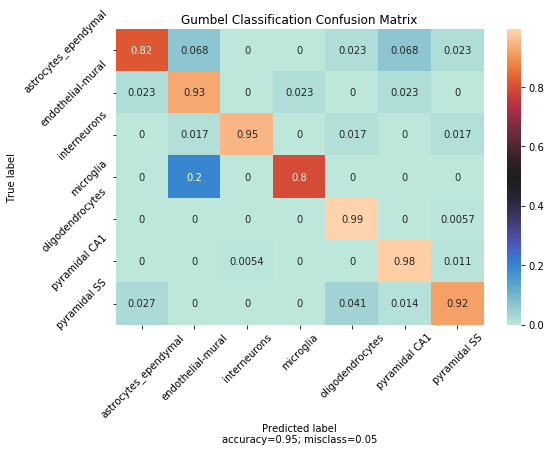

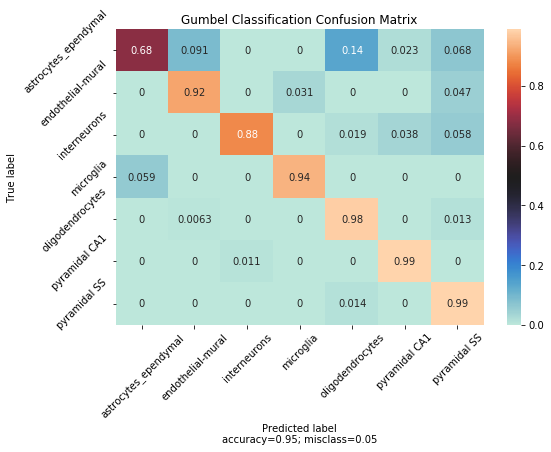

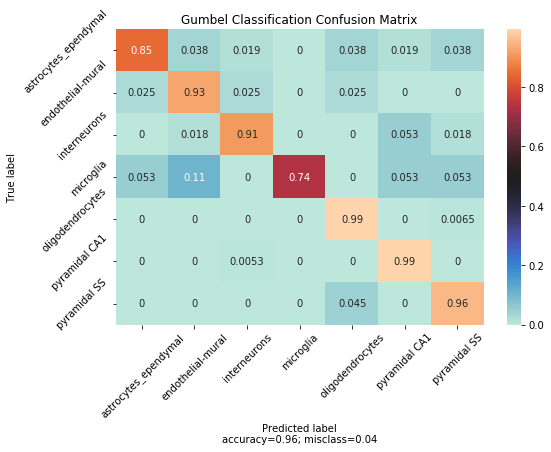

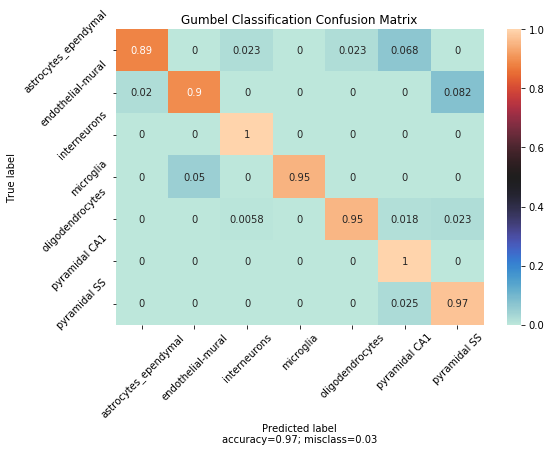

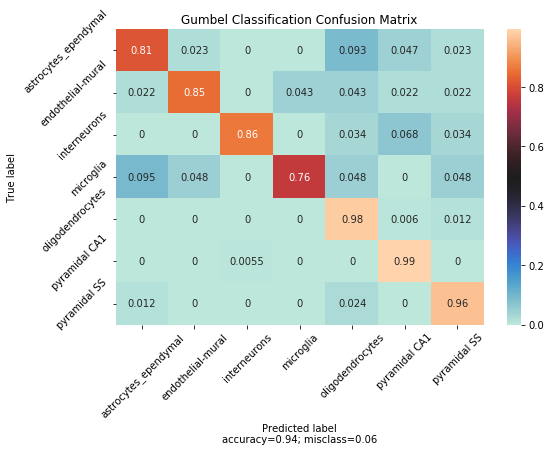

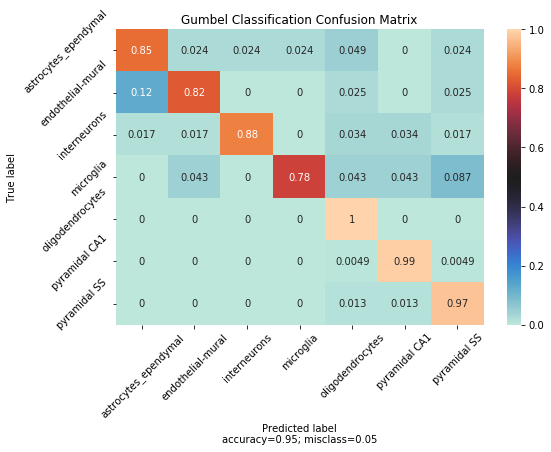

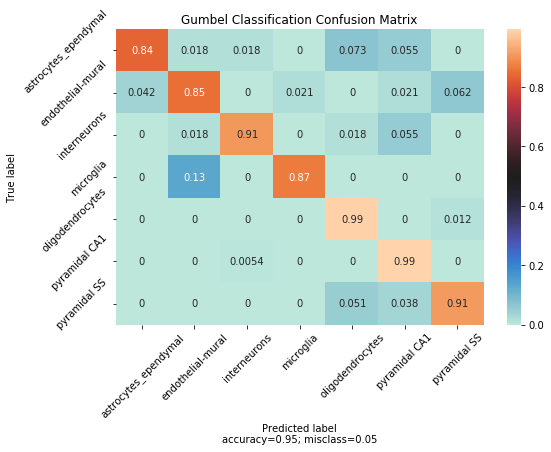

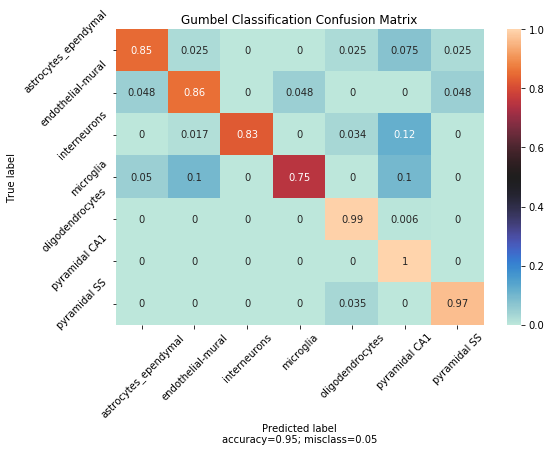

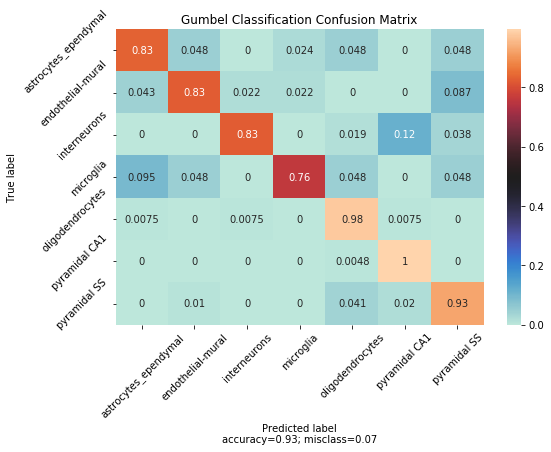

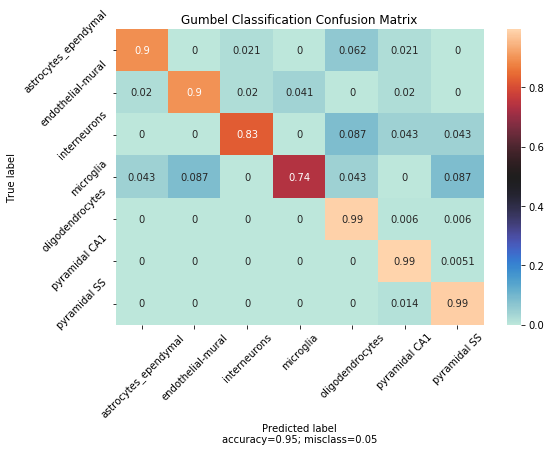

In [ ]:
for tryy in range(1,num_times+1):
    results = np.load(model_save_path + 'gumbel_classification_results_{}.npy'.format(tryy), allow_pickle = True)
    plot_confusion_matrix(results[2], encoder.classes_, title = 'Gumbel Classification Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
for tryy in range(1,num_times+1):
    # Recon
    tmp_path = model_save_path + 'gumbel_classification_recon_{}.ckpt'.format(tryy)
    marker_indices = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle=True)
    recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

    l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
    jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
        test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

    results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    np.save(model_save_path + 'gumbel_classification_recon_results_{}.npy'.format(tryy), results)

    print("tryy=", tryy, ": ")
    print(l2_all, l2_by_group)
    print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
    print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
33.38422351620948 [28.5549723  28.5304869  36.34655911 30.14906555 32.6687088  34.87769471
 36.6355826 ]
0.797752808988764 [0.48285449 0.42602496 0.35249366 0.41718335 0.5503876  0.45190563
 0.4059754 ] 0.9361611697600729 [0.6913988  0.59334184 0.68405938 0.60420885 0.85235557 0.79497559
 0.73235098] 0.0 [0. 0. 0. 0. 0. 0. 0.]



/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 2 : 
33.14679319739623 [29.40105153 28.40330146 36.34750952 29.81045822 32.32835343 34.44502
 36.25301213]
0.7817371937639198 [0.51228733 0.47737765 0.36635354 0.41969831 0.52091255 0.44927536
 0.4084507 ] 0.9261522696970168 [0.73027681 0.67287925 0.68693808 0.60229802 0.81626666 0.79990085
 0.72504083] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 3 : 
33.1393185924768 [28.53033926 28.29290701 36.07176608 30.27982205 32.47464465 34.53452332
 36.28954889]
0.7601760176017601 [0.48011101 0.48148148 0.36518771 0.39130435 0.53846154 0.44534779
 0.43497758] 0.9262728740170545 [0.70155509 0.6738     0.69656052 0.61428117 0.80220514 0.80388193
 0.74338282] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 4 : 
33.11269659473029 [28.78536522 28.28538122 36.32663081 30.06004803 32.22473278 34.58579571
 36.24436803]
0.7640573318632855 [0.48560817 0.46788991 0.36170213 0.42857143 0.54440154 0.44144144
 0.41093474] 0.9274233052764564 [0.67377009 0.656849   0.69533604 0.62296362 0.83112859 0.80203043
 0.73645198] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 5 : 
32.91287751101472 [28.33130941 28.16523576 35.99776943 29.86761837 32.20466065 34.30070647
 36.06019457]
0.7679558011049724 [0.48975791 0.4732965  0.34566863 0.44144144 0.53698367 0.44144144
 0.42222222] 0.9261667956979246 [0.68844352 0.64112377 0.68476952 0.6413158  0.81902349 0.80053813
 0.74446798] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 6 : 
33.27695880306417 [28.80875901 28.59160069 36.11535387 30.20900585 32.70544171 34.62258455
 36.2697873 ]
0.7524644030668127 [0.44927536 0.39009557 0.34566863 0.42602496 0.54291225 0.44404332
 0.4084507 ] 0.9247169361073083 [0.65425312 0.56243731 0.67385693 0.62001152 0.83514249 0.81140259
 0.73734302] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 7 : 
33.18677406105287 [28.55582806 28.3431261  35.99187589 30.19411189 32.5200908  34.61459857
 36.38932156]
0.756311745334797 [0.49812734 0.4479638  0.37931034 0.41342756 0.54440154 0.47465438
 0.42729706] 0.9279807167487947 [0.70713773 0.61188229 0.69666976 0.59560312 0.82972028 0.82119485
 0.74590989] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 8 : 
33.38875204139359 [29.65362728 28.36467874 36.12069033 30.48062106 32.64356659 34.75910329
 36.47402908]
0.7758046614872364 [0.46520147 0.44014401 0.38528139 0.4159292  0.56709109 0.44534779
 0.39982502] 0.9316992555561269 [0.66296432 0.6027973  0.69720404 0.58861953 0.86716138 0.78644505
 0.7429533 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 9 : 
33.13643633530941 [28.78342544 28.3070039  36.00574191 29.90554188 32.34317712 34.65164671
 36.22909273]
0.7997750281214848 [0.54589372 0.44534779 0.35249366 0.44927536 0.52963671 0.45454545
 0.39372822] 0.9337531450283411 [0.75818105 0.61567141 0.69112437 0.61777498 0.80021436 0.80610714
 0.72505619] 0.0 [0. 0. 0. 0. 0. 0. 0.]



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 10 : 
33.13070294946756 [28.63133963 28.42430826 36.11694711 29.92211959 32.34398102 34.51903388
 36.49294635]
0.7718715393133998 [0.46654445 0.48423006 0.37221269 0.38888889 0.51515152 0.44665461
 0.39494333] 0.9285454877840928 [0.68702898 0.65997503 0.69275425 0.55780038 0.80691699 0.80282474
 0.74060698] 0.0 [0. 0. 0. 0. 0. 0. 0.]



# Varability loss 

In [ ]:
import sys
from importlib import reload

classifier = reload(sys.modules['src.myexp.classifier'])

In [ ]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

X2 = scprep.normalize.batch_mean_center(X)
var_X2 = scprep.measure.gene_variability(X2)

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

model = classifier.GumbelFCVarClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, var_X = var_X2, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

tmp_path = model_save_path + 'gumbel_classification_var_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 100, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
np.save(model_save_path + 'gumbel_classification_var_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'gumbel_classification_var_markers_{}.npy'.format(tryy), markers)
plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
        path = viz_save_path + 'gumbel_classification_var_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


In [ ]:
np.sum(var_X2[markers]) / np.sum(var_X2)

0.07438302

0.53087497
4 < 0
[ 0.7283175   0.23620525  1.769205    0.42089224  0.54633033  0.304762
  0.41662455  0.9171678   0.82796717  0.08087882  3.5502028   0.02574524
  0.14379019  0.713305    0.19580948  1.2670692   0.09786749  0.12774578
 -0.13434404  0.41074318  0.45090687  0.07631502 -0.09333956  0.4491563
  1.005318   -0.04877979  2.0437284   1.5083871   0.49403659  0.44066536
  0.02000356  0.0601626   0.13204959  0.05309308  0.48734975  0.23888105
  0.08973086  0.7582876   0.35206944  0.28897297  0.7307922   0.59491944
  0.88595307  1.0864706   0.52450264  0.6180641   0.06435633  0.03062624
 -0.22431198  0.7790946 ]


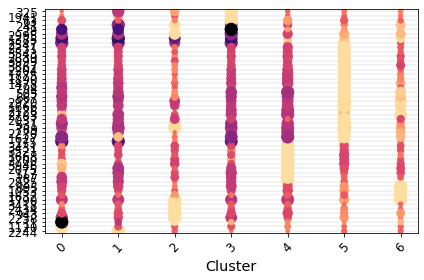

In [ ]:
print(np.mean(var_X2[markers])) # 0.5094528 4 < 0 
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
names = list(range(0,X.shape[1]))
scprep.plot.marker_plot(X, y, markers, names)

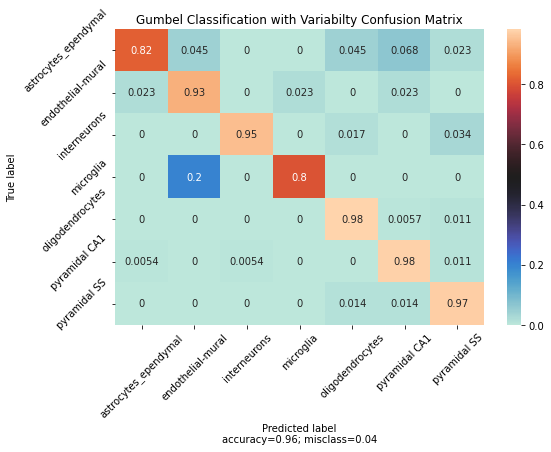

In [ ]:
# results = np.load(model_save_path + 'gumbel_classification_var_results_{}.npy'.format(tryy), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Gumbel Classification with Variabilty Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
# Recon
tmp_path = model_save_path + 'gumbel_classification_var_recon_{}.ckpt'.format(tryy)
marker_indices = np.load(model_save_path + 'gumbel_classification_var_markers_{}.npy'.format(tryy), allow_pickle=True)
recon_test_x = recon.trainAndGetRecon(hidden_layer_size, z_size, marker_indices, train_dataloader, val_dataloader, test_x, tmp_path, gpus)

l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'gumbel_classification_var_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

tryy= 1 : 
32.98185336048155 [28.1356287  28.95184959 36.69679695 29.78626234 31.56124822 34.33239261
 36.14456063]
0.7660044150110376 [0.5625     0.4995314  0.32122213 0.42984808 0.5037594  0.4505893
 0.40350877] 0.9220401036275063 [0.7790816  0.69933114 0.6935795  0.6596651  0.75952011 0.79870201
 0.74176336] 0.0 [0. 0. 0. 0. 0. 0. 0.]



/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


# PEDCC Classifier

In [ ]:
from src.myexp import PEDCCvae

In [ ]:
import sys
from importlib import reload

PEDCC = reload(sys.modules['src.myexp.PEDCC'])
PEDCCclassifier = reload(sys.modules['src.myexp.PEDCCclassifier'])
PEDCCvae = reload(sys.modules['src.myexp.PEDCCvae'])

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))
# generate centroids for n-classes on z-dim hypersphere
PEDCC.centroids(len(encoder.classes_), z_size, c_path)

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))

tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

model = PEDCCclassifier.pedccClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

tmp_path = model_save_path + 'pedcc_classification_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 500, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
np.save(model_save_path + 'pedcc_classification_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'pedcc_classification_markers_{}.npy'.format(tryy), markers)
plot_umap_embedding(X, y, encoder, 'PEDCC Classification Marker Visualization', 
        path = viz_save_path + 'pedcc_classification_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


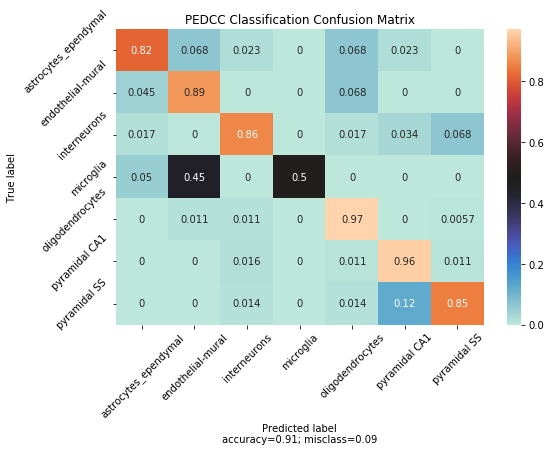

In [ ]:
results = np.load(model_save_path + 'pedcc_classification_results_{}.npy'.format(tryy), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'PEDCC Classification Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


## PEDCC vae

In [ ]:
import sys
from importlib import reload

PEDCCvae = reload(sys.modules['src.myexp.PEDCCvae'])

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))

tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

train_x = X[np.concatenate([train_indices, val_indices]), :]
train_y = y[np.concatenate([train_indices, val_indices])]
test_x = X[test_indices, :]
test_y = y[test_indices]

# marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

model = PEDCCvae.PEDCCvae(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
            k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
            batch_norm = batch_norm)

tmp_path = model_save_path + 'pedcc_vae_{}.ckpt'.format(tryy)
train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                    min_epochs = 25, max_epochs = 500, auto_lr = True,
                early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
markers = model.markers().clone().cpu().detach().numpy()

results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
np.save(model_save_path + 'pedcc_vae_results_{}.npy'.format(tryy), results)
np.save(model_save_path + 'pedcc_vae_markers_{}.npy'.format(tryy), markers)
plot_umap_embedding(X, y, encoder, 'PEDCC VAE Marker Visualization', 
        path = viz_save_path + 'pedcc_vae_markers_{}.png'.format(tryy), markers = markers, close_fig = True)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
misclass_rate, test_rep, cm = np.load(model_save_path + 'pedcc_vae_results_{}.npy'.format(tryy), allow_pickle=True)
print(misclass_rate, test_rep['weighted avg']['f1-score'])

0.07820299500831951 0.9188540699292462


0.54807234
10 < 0
[ 0.44612408 -0.06783384  0.04738128  0.02451694  1.2940686   0.5831046
  0.3341881   0.33732355  1.2267361   0.05335748  1.8906931  -0.02027106
  0.876464    0.30976915 -0.07565063 -0.00651768  0.9868076   5.577954
  0.0996033   0.6479119   0.12753677  0.29688418  1.2616671   0.2566359
  0.7027824   0.5688163   0.53938645  0.48371285  0.19534302  0.
  0.20249796  0.2513649   2.3787942   0.8176997  -0.13763237  0.34784156
 -0.036461   -0.30845034  1.9979532   0.20862839  0.15724349 -0.01315951
 -0.5061484   1.0377814   1.062665    0.22803825  0.5219817  -0.03165597
  0.06478032  0.16135734]


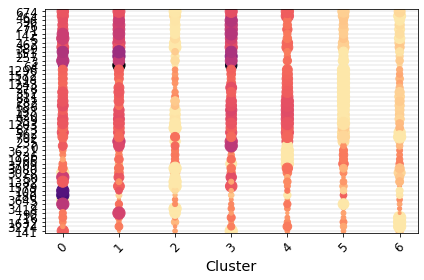

In [ ]:
X2 = scprep.normalize.batch_mean_center(X)
var_X2 = scprep.measure.gene_variability(X2)
print(np.mean(var_X2[markers])) # 0.5094528 4 < 0 
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
names = list(range(0,X.shape[1]))
scprep.plot.marker_plot(X, y, markers, names)

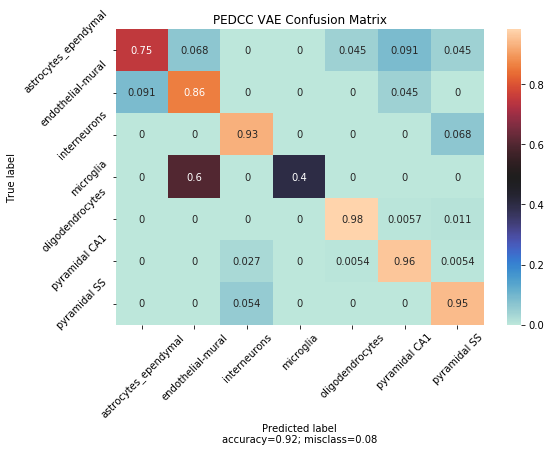

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'PEDCC VAE Confusion Matrix', save_path = viz_save_path + 'gumbel_classification_cm.pdf', cmap = 'icefire')


In [ ]:
recon_test_x = model.get_reconstruction(test_x)
l2_all, l2_by_group = recon.getL2(test_x, recon_test_x, test_y, np.unique(y))
jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p = recon.analyzeVariance(
    test_x, recon_test_x, test_y, np.unique(y), int(test_x.shape[1]*0.2))

results = (l2_all, l2_by_group, jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
np.save(model_save_path + 'marker_map_unsupervised_recon_results_{}.npy'.format(tryy), results)

print("tryy=", tryy, ": ")
print(l2_all, l2_by_group)
print(jaccard_all, jaccard_index, spearman_rho_all, spearman_rho, spearman_p_all, spearman_p)
print()


tryy= 1 : 
33.09781744549219 [28.93033027 29.0656805  36.36122658 29.58927741 31.65149442 34.42976197
 36.41011359]
0.762114537444934 [0.49393091 0.43112701 0.37812231 0.3986014  0.48698885 0.45454545
 0.42602496] 0.9274630716349167 [0.69892556 0.63443312 0.71771527 0.57588637 0.76387418 0.79914013
 0.7220622 ] 0.0 [0. 0. 0. 0. 0. 0. 0.]



/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


# Plot markers
Color of each point indicates the expression of each gene in each cluster. The size of each point indicates how differentially expressed each gene is in each cluster.

0.052832995
1988 < 0
[-0.5061484   0.1315726   0.20249796 ... -0.2959833  -0.18029562
  1.1944602 ]


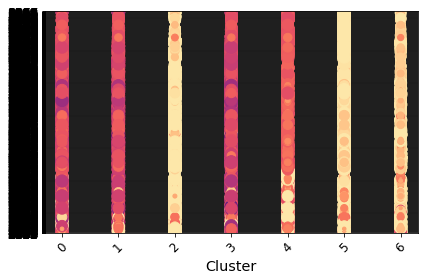

In [ ]:
markers = np.load(model_save_path + 'all_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

1.0407379
3 < 0
[ 1.9979532e+00  1.1898124e+00  8.4832603e-01  1.1944602e+00
  1.1564617e+00  1.5201222e+00  4.5927167e-01  1.0480376e+00
  3.1763142e-01 -2.4477589e-01  1.5329592e+00  8.6032760e-01
  1.5331601e+00  9.4835716e-01  6.6387379e-01  1.2090876e+00
  3.2959449e+00  4.0524992e-01  5.5779538e+00  1.2940686e+00
  5.8310461e-01  4.9023312e-01  7.3370707e-01  1.5201271e-02
  1.3157260e-01  8.4170103e-03  1.4303362e+00  1.2750983e+00
 -1.7598033e-01  9.9082160e-01  2.1001875e+00  2.3395720e+00
  5.2791733e-01  5.4673994e-01  1.4079101e+00  2.0405149e+00
  5.5096149e-03  2.3285747e+00  8.3137608e-01  3.7874854e-01
 -8.0833375e-02  4.7014737e-01  1.6870117e+00  4.9096620e-01
  7.5738406e-01  1.2355806e+00  1.3984083e+00  2.6995033e-01
  1.1229783e-01  8.9813554e-01]


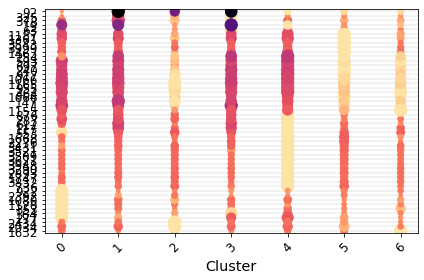

In [ ]:
markers = np.load(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

0.4503986
15 < 0
[ 3.67203951e-02  3.29594493e+00  2.01768637e-01  2.96671152e-01
  3.26856256e-01  5.56293130e-02  1.41574979e-01  5.26518106e-01
 -4.03041124e-01  1.41771078e-01  8.60327601e-01 -1.77815437e-01
  1.04803765e+00  4.25888211e-01  2.74167210e-01  1.04641008e+00
  2.39950418e-01 -8.35748911e-02  0.00000000e+00  1.34258091e-01
  1.19446015e+00  1.72368705e-01  1.66545272e-01  5.57795382e+00
 -1.08354986e-01  5.06077647e-01  1.99795318e+00  1.21508420e-01
  1.21825576e+00 -1.63149834e-03  2.95155406e-01  2.33957195e+00
  1.03667319e-01  7.41747022e-01 -1.42250866e-01 -2.61670887e-01
  4.90966201e-01 -2.60347486e-01 -9.11355019e-03 -1.07155681e-01
  1.06818080e-01 -1.70718193e-01  9.31300521e-02 -9.77916121e-02
  3.69254529e-01 -1.57157242e-01 -1.28852069e-01 -8.61050487e-02
  1.12536371e-01  5.50483465e-02]


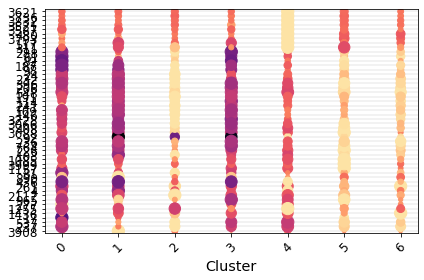

In [ ]:
markers = np.load(model_save_path + 'smash_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

0.57187027
6 < 0
[ 0.1154843  -0.09335601  0.75738406  0.66383994  0.39137888  0.5265181
  0.4852656   0.11229783 -0.6450521   0.21952558  0.666543    0.2537992
  0.89813554  0.75315374  0.75486124  0.6275083   1.1944602   0.45223117
 -0.02574652  0.54089034  1.9979532   0.59031975  0.39085102  1.2750983
  1.1898124   0.7337071   0.42276052  0.38524318  0.05335748 -0.01808035
  0.7027824   0.55150414  0.40524992  3.295945    0.03497565 -0.07565063
  2.1001875   0.04728433 -0.07032076  0.26995033  1.4303362   1.0167143
  0.          0.94835716  0.4909662   0.01021975  0.31763142  0.848326
  0.0158053   0.5831046 ]


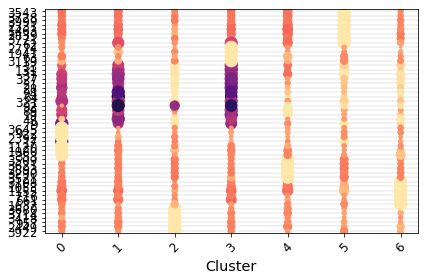

In [ ]:
markers = np.load(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

-0.054803047
36 < 0
[-0.17094843 -0.10872298 -0.09841737 -0.05877101 -0.15375352  0.04113147
 -0.06905058 -0.14161658 -0.01658404  0.15041375 -0.21765937 -0.10069916
 -0.0040924  -0.08533806 -0.0356802  -0.10133132 -0.03325889  0.02614248
  0.1196281   0.11113152 -0.12695423 -0.0389494   0.04033291 -0.12661657
 -0.01807645 -0.03653684 -0.09132871 -0.14379169 -0.04293635 -0.17326218
 -0.21452178 -0.12885207  0.01452297  0.04945239 -0.076294   -0.09893695
 -0.13431275  0.04308259 -0.11055195  0.03478274 -0.14454822 -0.13399205
  0.07972768 -0.01354107  0.04731622  0.0005286   0.18194807 -0.22060649
 -0.10492662 -0.10483357]


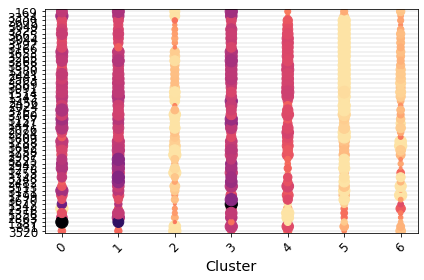

In [ ]:
markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

0.0682547
28 < 0
[ 2.21788585e-01 -8.48726630e-02  9.70745683e-02  1.15627825e-01
  4.44793701e-03 -2.00637400e-01 -2.44775891e-01 -1.63716078e-03
  1.18485868e-01 -4.22776639e-02  2.33161867e-01 -7.86194801e-02
 -1.20615065e-01  3.94281447e-01 -1.92872122e-01 -7.38877654e-02
 -1.12637758e-01 -5.01345992e-02  5.09179235e-01  1.83984399e-01
  5.27743697e-02  6.63873792e-01  2.10018754e+00  5.72610199e-02
 -1.42780840e-02  4.43228602e-01 -9.36147869e-02 -1.14129603e-01
 -8.41686130e-03 -1.30635113e-01  8.16380084e-02  7.65640736e-02
 -6.41812384e-02 -7.72718191e-02 -8.53380561e-02 -2.36483023e-01
 -3.43525708e-02  6.12115264e-02  4.03329134e-02 -9.24585462e-02
 -9.61306393e-02  2.38159299e-02 -1.35261238e-01  3.51636291e-01
 -6.87912703e-02  1.20733380e-01  3.17874849e-02 -2.90769935e-02
 -6.17299974e-02 -2.52242684e-02]


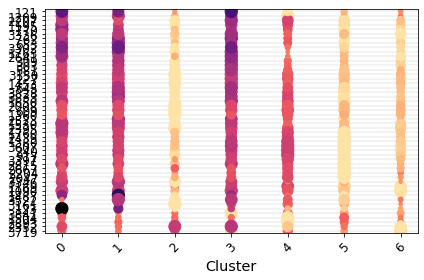

In [ ]:
markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

0.02580849
21 < 0
[ 0.03764156 -0.12399071  0.23472422 -0.0981704  -0.02954823  0.05151188
 -0.04789922  0.13642415  0.09705633  0.         -0.13428167  0.14002728
  0.15397483  0.1173929   0.03785247  0.3458817   0.23921138 -0.03825414
 -0.18817493 -0.12787053  0.16319066  0.2976159   0.11848587 -0.05520558
 -0.506937    0.33882415 -0.12532479 -0.07394034  0.00676876 -0.143261
 -0.09525043  0.05673128 -0.02452862  0.04551679  0.08210763  0.04811722
  0.03251001 -0.0007419   0.29003668 -0.11308962  0.00132358  0.20388862
  0.09021613 -0.11211105  0.07656407  0.02827856 -0.01977336 -0.1573481
 -0.0571121   0.09136373]


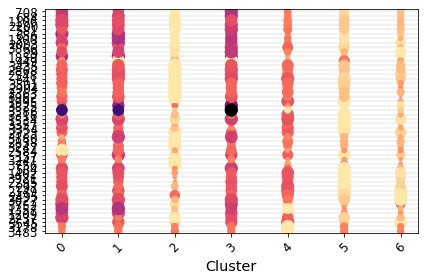

In [ ]:
markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

1.0733615
1 < 0
[ 5.577954    1.2267361   1.1263628   1.1944602   0.86083555  1.1564617
  1.2940686   1.1898124   0.5831046  -0.5061484   3.295945    1.5331601
  1.4079101   1.0377814   0.37874854  0.8313761   1.4303362   1.2520592
  0.38524318  1.5329592   0.848326    0.7890986   0.7337071   0.75315374
  0.75738406  1.2018477   0.7027824   0.5265181   0.8603276   2.040515
  0.57574606  0.89813554  1.2090876   2.3285747   2.1001875   0.57110405
  0.91210526  0.4909662   0.6582577   0.50607765  0.741747    1.9979532
  1.0480376   0.20249796  0.74993324  0.39085102  0.0367204   0.75486124
  0.90208507  0.59031975]


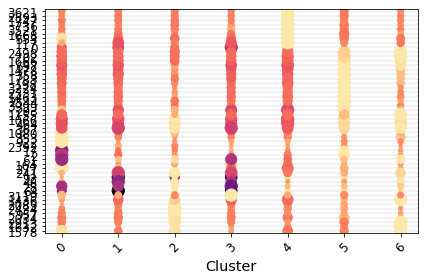

In [ ]:
markers = np.load(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), allow_pickle=True)
print(misclass_rate, test_rep['weighted avg']['f1-score'])

0.19633943427620637 0.78328376697753


0.49372783
4 < 0
[ 1.2940686   0.61492264  0.54673994  0.82814395  0.26720256  0.61036503
  0.10288906  1.3933524   0.45927167  0.4557469   0.3047437   0.10068035
  0.29670334  0.08094841  0.4217788   0.36640865  1.4079101   0.11665916
  0.6652969  -0.01315951  0.17242873  0.9908216   0.13390678 -0.11385643
  0.42744195  0.73218656  0.4424293   0.5279173   0.5240164   0.40698934
  0.02061182  1.0902364   1.5331601   0.20215154  0.86147714  0.5835355
  0.7577995   0.0753876   0.36379367  0.5252086   0.10610414  0.7855586
  0.624208    0.2197181   0.22317737  1.155201   -0.05861396  0.59909546
  0.47389734 -0.02027106]


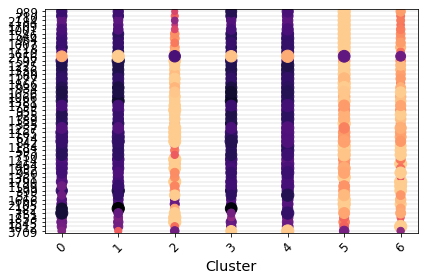

In [ ]:
markers = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), allow_pickle=True)
print(misclass_rate, test_rep['weighted avg']['f1-score'])

0.05823627287853572 0.9412501488203155


0.57274497
8 < 0
[ 0.4909662   0.25009763  0.4163745   0.75738406  0.5831046   0.54008514
  0.5537901   0.5856843   0.20573533  0.31763142  2.1001875   1.5329592
  0.57574606  0.06042165  0.4852656   0.06187341  0.7337071   0.38524318
  0.93864465  0.49023312  0.12150842  1.1898124   0.75315374  0.39137888
  0.15722603 -0.03804868  0.74993324 -0.07032076  0.7170533   0.6359633
  0.37994272 -0.08083338 -0.02490786  1.1944602  -0.07001132  0.5688163
  0.23316187  0.29003668  2.040515   -0.02458695  0.14485434  0.666543
  0.02349478  3.295945   -0.01811099  0.7890986   0.8313761   1.2090876
 -0.14268756  0.6582577 ]


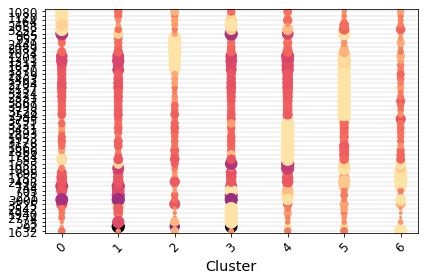

In [ ]:
markers = np.load(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

In [ ]:
misclass_rate, test_rep, cm = np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), allow_pickle=True)
print(misclass_rate, test_rep['weighted avg']['f1-score'])

0.08485856905158073 0.9089344122333299


0.4763351
11 < 0
[ 0.3458817  -0.10715568  0.65604854  0.3351616   0.5831046   0.1839844
  1.8906931   0.18130797 -0.00985968  0.01896167 -0.06950247  0.1723687
 -0.12461543  0.3095634   1.1898124   1.0148253   0.48371285  1.3933524
  1.0464101   0.2763745   0.05062467 -0.4739585   2.0255392  -0.13763237
 -0.04476833  0.5219817   1.2520592  -0.15463316  0.37113678  0.10275131
  0.04158551 -0.40304112  0.9868076   0.39434183 -0.01328304  1.2267361
  1.062665    1.1263628   0.5279173  -0.06588107  0.10340184  2.040515
  1.2355806   0.54008514  0.02451694  0.          0.46129835  0.7890986
  0.30558056  0.148938  ]


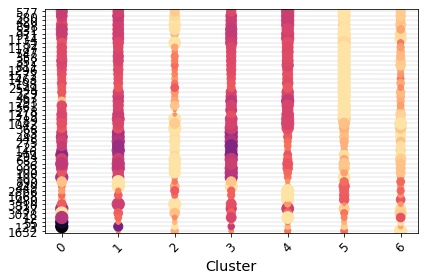

In [ ]:
markers = np.load(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

0.4198738
9 < 0
[ 0.4909662   0.5537901   0.31401888  0.5856843   0.4343879   0.24589753
  0.37913322  1.0480376   0.31763142  0.4319891   0.12205404  0.5868251
  0.57574606  0.          0.06187341  0.26995033  0.38524318  0.40524992
 -0.01808035  0.93864465  0.04860747 -0.4739585  -0.02490786  0.39752162
  0.09707457  1.2520592  -0.02027106  0.4173508  -0.03148043  0.09504157
 -0.09650546 -0.08083338  0.75315374  1.1944602   0.23316187  0.29003668
  0.848326    0.4351886   0.666543    0.2537992   0.25009763  0.5831046
 -0.08992323  0.7890986  -0.00985634  0.15981758  0.6582577   0.8313761
  0.1423631   3.295945  ]


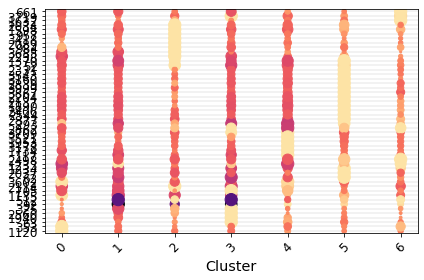

In [ ]:
markers = np.load(model_save_path + 'gumbel_classification_markers_{}.npy'.format(tryy), allow_pickle = True)
print(np.mean(var_X2[markers]))
print("{} < 0".format(np.sum(var_X2[markers]<0)))
print(var_X2[markers])
scprep.plot.marker_plot(X, y, markers, names)

# Different k

In [ ]:
c_path = model_save_path + 'PEDCC_{}.pkl'.format(np.unique(y))
for k in k_range:
    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = PEDCCvae.PEDCCvae(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
            k = k, c_path = c_path, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
            batch_norm = batch_norm)

    tmp_path = model_save_path + 'pedcc_vae_{}_{}.ckpt'.format(k,tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'pedcc_vae_results_{}_{}.npy'.format(k,tryy), results)
    np.save(model_save_path + 'pedcc_vae_markers_{}_{}.npy'.format(k,tryy), markers)
    plot_umap_embedding(X, y, encoder, 'PEDCC VAE Marker Visualization', 
          path = viz_save_path + 'pedcc_vae_markers_{}_{}.png'.format(k,tryy),
           markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


In [ ]:
for k in k_range:
    misclass_rate, test_rep, cm = np.load(model_save_path + 'pedcc_vae_results_{}_{}.npy'.format(k,tryy), allow_pickle=True)
    print(1-misclass_rate, test_rep['weighted avg']['f1-score'])

0.7470881863560732 0.718276504807443
0.9251247920133111 0.9171829604139062
0.9500831946755408 0.949494242329987
0.961730449251248 0.9595957220905769


In [ ]:
for k in k_range:
    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = classifier.GumbelFCClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                        k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                        batch_norm = batch_norm)

    tmp_path = model_save_path + 'gumbel_classification_{}_{}.ckpt'.format(k,tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'gumbel_classification_results_{}_{}.npy'.format(k,tryy), results)
    np.save(model_save_path + 'gumbel_classification_markers_{}_{}.npy'.format(k,tryy), markers)
    plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
          path = viz_save_path + 'gumbel_classification_markers_{}_{}.png'.format(k,tryy),
           markers = markers, close_fig = True)

In [ ]:
for k in k_range:
    misclass_rate, test_rep, cm = np.load(model_save_path + 'gumbel_classification_results_{}_{}.npy'.format(k,tryy), allow_pickle=True)
    print(1-misclass_rate, test_rep['weighted avg']['f1-score'])

0.8735440931780366 0.8703161272918419
0.9534109816971714 0.9528763949323322
0.9667221297836939 0.9663310579411268
0.9600665557404326 0.9595327171612849


0.6885444
Total of 10 markers, 0 < 0
0.40319607
Total of 50 markers, 7 < 0
0.30610776
Total of 100 markers, 22 < 0
0.16724108
Total of 250 markers, 97 < 0


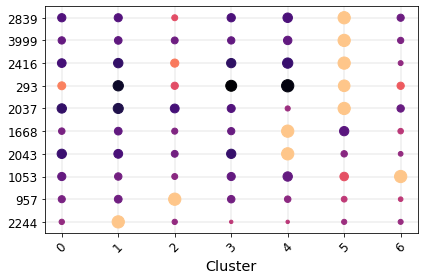

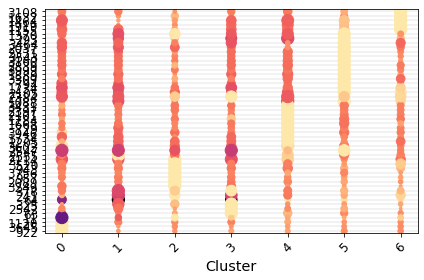

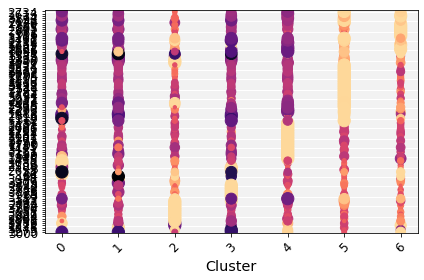

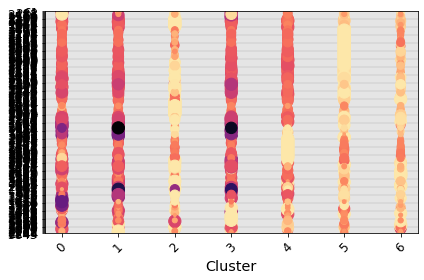

In [ ]:
for k in k_range:
    markers = np.load(model_save_path + 'gumbel_classification_markers_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    print(np.mean(var_X2[markers]))
    print("Total of {} markers, {} < 0".format(k, np.sum(var_X2[markers]<0)))
    # print(var_X2[markers])
    scprep.plot.marker_plot(X, y, markers, names)

## Var + different k

In [ ]:
tryy = 1
split = np.load(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), allow_pickle=True)
train_indices = split[0]
val_indices = split[1]
test_indices = split[2]

for k in k_range:
    train_x = X[np.concatenate([train_indices, val_indices]), :]
    train_y = y[np.concatenate([train_indices, val_indices])]
    test_x = X[test_indices, :]
    test_y = y[test_indices]

    # marker_indices = np.load(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), allow_pickle=True)
    train_dataloader, val_dataloader = recon.make_dataloaders(X, y, train_indices, val_indices)

    model = classifier.GumbelFCVarClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                    k = k, var_X = var_X2, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95,
                    batch_norm = batch_norm)

    tmp_path = model_save_path + 'gumbel_classification_var_{}_{}.ckpt'.format(k,tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                        min_epochs = 25, max_epochs = 100, auto_lr = True,
                    early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()

    results = new_model_metrics(train_x, train_y, test_x, test_y, markers = markers)
    np.save(model_save_path + 'gumbel_classification_var_results_{}_{}.npy'.format(k,tryy), results)
    np.save(model_save_path + 'gumbel_classification_var_markers_{}_{}.npy'.format(k,tryy), markers)
    plot_umap_embedding(X, y, encoder, 'Gumbel Classification Marker Visualization', 
          path = viz_save_path + 'gumbel_classification_markers_var_{}_{}.png'.format(k,tryy),
           markers = markers, close_fig = True)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  format.write_array(fid, arr, allow_pickle=allow_pickle,


In [ ]:
for k in k_range:
    markers = np.load(model_save_path + 'gumbel_classification_var_markers_{}_{}.npy'.format(k,tryy), allow_pickle = True)
    print(np.mean(var_X2[markers]))
    print("Total of {} markers, {} < 0".format(k, np.sum(var_X2[markers]<0)))

0.7124568
Total of 10 markers, 0 < 0
0.49781382
Total of 50 markers, 7 < 0
0.373701
Total of 100 markers, 19 < 0
0.19464307
Total of 250 markers, 92 < 0
